# Route Inspection Problem
### (Chinese Postman Problem)

> To find the shortest closed path which visits every edge of a (connected) undirected graph.

## Conceptual Solution

A **Eulerian circuit** should exist in the graph: a closed-circuit path which visits every edge *exactly once*.

If such a circuit does not exist, generate that condition from the given graph: 

>Find the minimal set of the graph's edges to duplicate such that the resulting multigraph **does** have a Eulerian circuit.

The subset of edges must have the minimum possible total weight, or if edge weight is a non-factor, the smallest number of edges.

## Algorithm (generalised)

1. Find all nodes with an odd [degree](https://en.wikipedia.org/wiki/Degree_(graph_theory)).

2. Add edges to the graph such that odd-degree nodes become even-degree (accounts for and minimises backtracking): 
   
> any edges added must be duplicates of graph's original edges
    
> the added set of edges must have minimal total weight (np-hard)
    
3. Find the Eulerian circuit in the regenerated multigraph.

----

## Data Preparation

Gather dependencies:

In [1]:
# stdlib dependencies
import itertools
import copy

# external libraries
import networkx as nx
import pandas   as pd
import matplotlib.pyplot as plt

Obtain external data:

> We use a dataset that maps connections/intersections between various hiking trails in Sleeping Giant Provincial Park (Ontario, Canada).

In [16]:
import io
import requests as r

NODE_CSV = 'https://gist.githubusercontent.com/brooksandrew/f989e10af17fb4c85b11409fea47895b/raw/a3a8da0fa5b094f1ca9d82e1642b384889ae16e8/nodelist_sleeping_giant.csv'
EDGE_CSV = 'https://gist.githubusercontent.com/brooksandrew/e570c38bcc72a8d102422f2af836513b/raw/89c76b2563dbc0e88384719a35cba0dfc04cd522/edgelist_sleeping_giant.csv'

nodes = pd.read_csv(io.StringIO(r.get(NODE_CSV).content.decode('utf-8')))
edges = pd.read_csv(io.StringIO(r.get(EDGE_CSV).content.decode('utf-8')))

Previewing data:

In [3]:
nodes

,id,X,Y
0,b_bv,1486,732
1,b_bw,716,1357
2,b_end_east,3164,1111
3,b_end_west,141,1938
4,b_g,1725,771
...,...,...,...
72,y_gy2,1939,1182
73,y_rc,1429,1491
74,y_rh,717,1852
75,y_rs,1805,1246


In [4]:
edges

,node1,node2,trail,distance,color,estimate
0,rs_end_north,v_rs,rs,0.30,red,0
1,v_rs,b_rs,rs,0.21,red,0
2,b_rs,g_rs,rs,0.11,red,0
3,g_rs,w_rs,rs,0.18,red,0
4,w_rs,o_rs,rs,0.21,red,0
...,...,...,...,...,...,...
118,v_bv,b_bv,bv,0.08,purple,0
119,g_gy2,w_gy2,gy2,0.05,yellowgreen,0
120,w_gy2,b_gy2,gy2,0.03,yellowgreen,1
121,b_gy2,o_gy2,gy2,0.07,yellowgreen,0


----

## Graph Creation

Begin by generating an empty graph:

In [5]:
g = nx.Graph()

Add edges and hydrate with edge attributes:

In [6]:
for _, row in edges.iterrows():
    g.add_edge(
        row[0],  # from node
        row[1],  # to node
        attr_dict=row[2:].to_dict()
    )

Now hydrate the graph with desired node attributes:

In [7]:
attrs = {
    row['id']: row[1:].to_dict()
    for _, row in nodes.iterrows()
}

nx.set_node_attributes(g, attrs)

In brief, the graph we've ended up with:

In [8]:
g.number_of_nodes(), g.number_of_edges()

(77, 123)

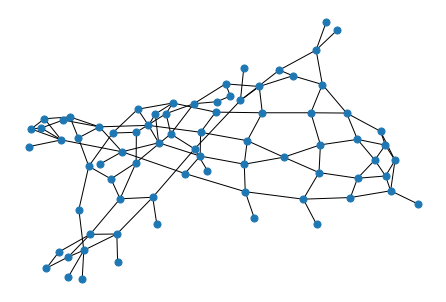

In [94]:
nx.draw(g, node_size=50)

----

## Visualization Prep

To control positional layout, first transcribe a `{node: (x, y), ...}` dictionary:

> `y` is negated so y-origin is at bottom-left, not top-left

In [11]:
node_positions = {
    nd: (g.nodes()[nd]['X'], -g.nodes()[nd]['Y'])
    for nd in g.nodes()
}

To control edge colour, gather that field from the provided data (wherein an edge belonging to a trail has that trail's colour):

In [13]:
edge_attr   = g.edges().values()
edge_colors = [e['attr_dict']['color'] for e in edge_attr] 

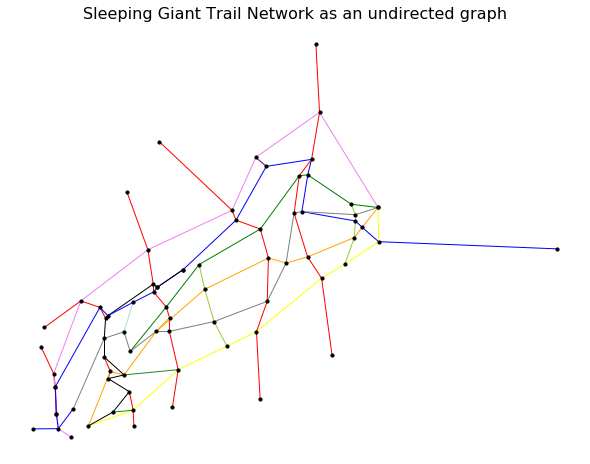

In [14]:
plt.figure(figsize=(8,6))

nx.draw(
    g,
    pos        = node_positions,
    edge_color = edge_colors,
    node_size  = 10,
    node_color = 'black'
)

plt.title('Sleeping Giant Trail Network as an undirected graph', size=16)
plt.show()

----

## Algorithm Implementation

1. **Find all nodes with an odd degree.**

In [18]:
odd_nodes = [node for node, degree in g.degree() if degree % 2]

f'Of {len(g.nodes())} total nodes, {len(odd_nodes)} have odd degree.'

'Of 77 total nodes, 36 have odd degree.'

----

2. **Compute the 'minimum' subset of edges that need to be duplicated to regenerate a graph where a Eulerian circuit can exist.**
    
    **a.** Compute all possible pair combinations of odd-degree nodes.
    
    **b.** Compute the shortest path between each node pair in `a`.
    
    **c.** Generate a [complete graph](https://en.wikipedia.org/wiki/Complete_graph) that connects each node pair from `a` with their respective shortest path attributes from `b`.
    
    **d.** Compute the [minimum weight matching](https://en.wikipedia.org/wiki/Matching_(graph_theory)) of `c`'s graph to obtain the minimum subset of the main graph's edges that need to be duplicated to allow a Eulerian circuit.
    
    **e.** "Add" the shortest path series between node pairs calculated in `d` to the main graph.

> **a.** compute all possible odd-degree nodes' pair combinations

In [43]:
odd_node_pairs = list(itertools.combinations(odd_nodes, 2))

> **b.** compute the shortest path between each node pair in `a`

In [46]:
weights = {}

for pair in odd_node_pairs:
    weights[pair] = nx.dijkstra_path_length(
        g,
        pair[0], pair[1],
        weight='distance'
    )

> **c.** generate a complete graph which connects each node pair from `a` with their respective shortest path attributes from `b`

In [64]:
cg = nx.Graph()

# flip weights because max weight matching algo is used, and we want min weights
for pair, w in weights.items():
        cg.add_edge(
            pair[0], pair[1],
            weight    = -w,
            attr_dict = {'distance': w}
        )

In [65]:
len(cg.nodes()), len(cg.edges())

(36, 630)

Let's pause and visualize the **complete graph** (fully connected graph) of odd-degree node pairs:

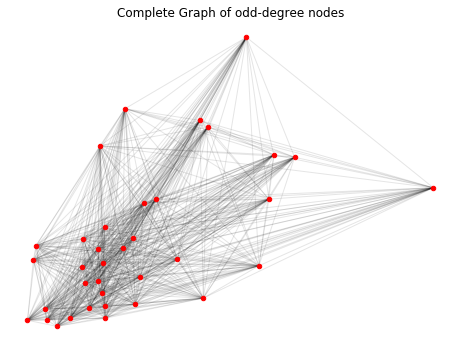

In [66]:
plt.figure(figsize=(8,5.85))

nx.draw_networkx_nodes(cg, node_positions, node_size=20, node_color='red')
nx.draw_networkx_edges(cg, node_positions, alpha=0.1)

plt.axis('off')
plt.title('Complete Graph of odd-degree nodes')
plt.show()

    
> **d.** compute the minimum weight matching of `c`'s complete graph to obtain the minimum subset of the main graph's edges that need to be duplicated

In [67]:
duplicates = nx.algorithms.max_weight_matching(cg, maxcardinality=True)

We would expect 36 edges, but the algorithm output is already deduplicated for us:

In [68]:
len(duplicates)

18

Let's view and inspect our result.

*Remember that the paths shown are abstract connections between odd-degree nodes. Some match actual paths on the trail map, while some are just expressions of connection intent - but we'll get to that.*

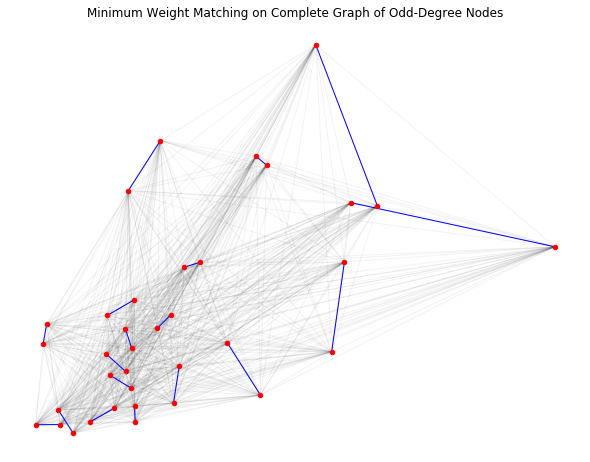

In [69]:
plt.figure(figsize=(8, 6))

# faintly redraw the complete graph above
nx.draw(
    cg,
    pos       = node_positions,
    node_size = 20,
    alpha     = 0.05    
)

# build and draw an overlay graph of the duplicate edges
dg = nx.Graph(list(duplicates))

nx.draw(
    dg,
    pos        = node_positions,
    node_size  = 20,
    edge_color = 'blue',
    node_color = 'red'
)

plt.title('Minimum Weight Matching on Complete Graph of Odd-Degree Nodes')
plt.show()

For a bit more clarity, we can overlay these abstract connections onto the actual trail map, to see which paths we will need to reconstruct:

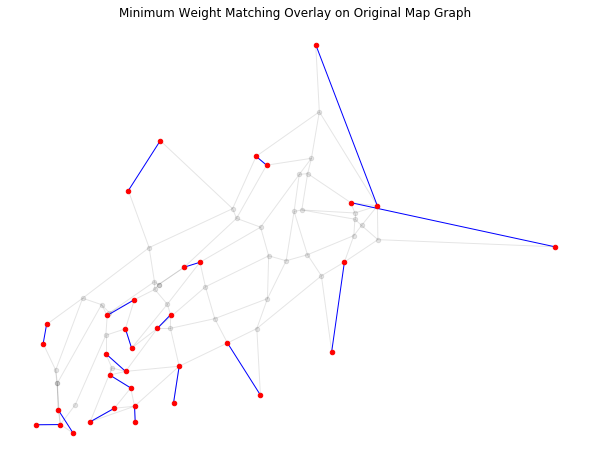

In [71]:
plt.figure(figsize=(8, 6))

# original trail map as graph
nx.draw(
    g,
    pos       = node_positions,
    node_size = 20,
    alpha     = 0.1,
    node_color= 'black'
)

# overlay of min weight match from complete graph of odd-degree nodes
nx.draw(
    dg,
    pos        = node_positions,
    node_size  = 20,
    alpha      = 1,
    node_color = 'red',
    edge_color = 'blue'
)

plt.title('Minimum Weight Matching Overlay on Original Map Graph')
plt.show()

> **e.** compute real paths from the connections expressed in `d`, and augment these to the main graph.

In [76]:
# a multigraph may have multiple edges between the same two nodes
augment = nx.MultiGraph(g.copy())

for pair in duplicates:
    augment.add_edge(
        pair[0], pair[1],
        attr_dict={
            'distance': nx.dijkstra_path_length(g, pair[0], pair[1]),
            'trail': 'augmented'
        }
    )

    Let's verify that these 18 edges have been added,

In [82]:
len(augment.edges()) - len(g.edges()) == 18

True

    and that every node in our graph now has an even degree:

In [91]:
pd.value_counts(list(dict(augment.degree()).values()))

4    54
2    18
6     5
dtype: int64

3. **Compute the Eulerian circuit (shortest path with each edge travelled only once).**